In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import pandas as pd
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
"""
Choose the training data set to be trained on.
"""
dataset = 1

if dataset==1:
    # Training Data set with 10e6 data points for gamma = 0.37, delta = 0.3
    X_train = np.array(pd.read_csv("X_train_mac_lots.csv", header=0, index_col=0))
    y_train = pd.read_csv("y_train_mac_lots.csv", header=0, index_col=0)
    X_test = np.array(pd.read_csv("X_test_mac_lots.csv", header=0, index_col=0))
    y_test = pd.read_csv("y_test_mac_lots.csv", header=0, index_col=0)
elif dataset==2:
    # Training Data set with 10e5 data points for gamma = 0.37, delta = 1
    X_train = np.array(pd.read_csv("X_train_delta1.csv", header=0, index_col=0))
    y_train = pd.read_csv("y_train_delta1.csv", header=0, index_col=0)
    X_test = np.array(pd.read_csv("X_test_delta1.csv", header=0, index_col=0))
    y_test = pd.read_csv("y_test_delta1.csv", header=0, index_col=0)

D:\Anaconda\envs\XAI\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = pd.DataFrame(scaler.transform(X_train), columns=['x0','v0','t'])
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=['x0','v0','t'])

In [56]:
# set up and train the network
input_shape = np.shape(X_train)[1]#, 1)
#opt = RMSprop()
opt = Adam(learning_rate=0.001, beta_1=0.7)

model = Sequential()
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
model.add(layers.Flatten())

model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(200, activation='relu'))

model.add(layers.Dense(32, activation='relu'))


model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(32, activation='tanh'))
"""
Try LSTM Next: need to do some data preprocessing
model.add(layers.LSTM(128))
model.add(layers.Embedding(input_dim=input_shape, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))
"""
model.add(layers.Dense(2))
loss='mse'
model.compile(optimizer=opt, loss=loss)
history=model.fit(X_train_scale, y_train, steps_per_epoch=None, epochs=5000, validation_split=0.2, batch_size=5096, shuffle=True, callbacks=callbacks, verbose=1)

Epoch 1/5000
1570/1570 [==============================] - 79s 50ms/step - loss: 0.2801 - val_loss: 0.2104
Epoch 2/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1963 - val_loss: 0.2063
Epoch 3/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1791 - val_loss: 0.1777
Epoch 4/5000
1570/1570 [==============================] - 79s 50ms/step - loss: 0.1700 - val_loss: 0.1707
Epoch 5/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1640 - val_loss: 0.1625
Epoch 6/5000
1570/1570 [==============================] - 77s 49ms/step - loss: 0.1590 - val_loss: 0.1626
Epoch 7/5000
1570/1570 [==============================] - 77s 49ms/step - loss: 0.1550 - val_loss: 0.1618
Epoch 8/5000
1570/1570 [==============================] - 78s 50ms/step - loss: 0.1516 - val_loss: 0.1489
Epoch 9/5000
1570/1570 [==============================] - 77s 49ms/step - loss: 0.1493 - val_loss: 0.1524
Epoch 10/5000
1570/1570 [=====================

In [57]:
# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(X_test_scale), columns=['xt','vt'])



In [58]:
pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y_test[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


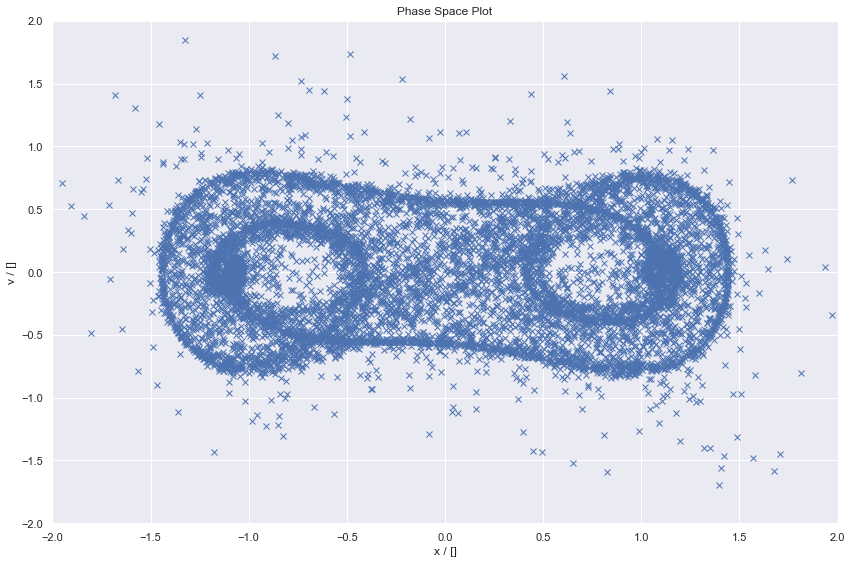

In [119]:
f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = y_test.iloc[:10000,:], x = 'xt', y='vt',ax=axs, marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x / []')
axs.set_ylabel('v / []')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("data_only.svg", dpi='figure')

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


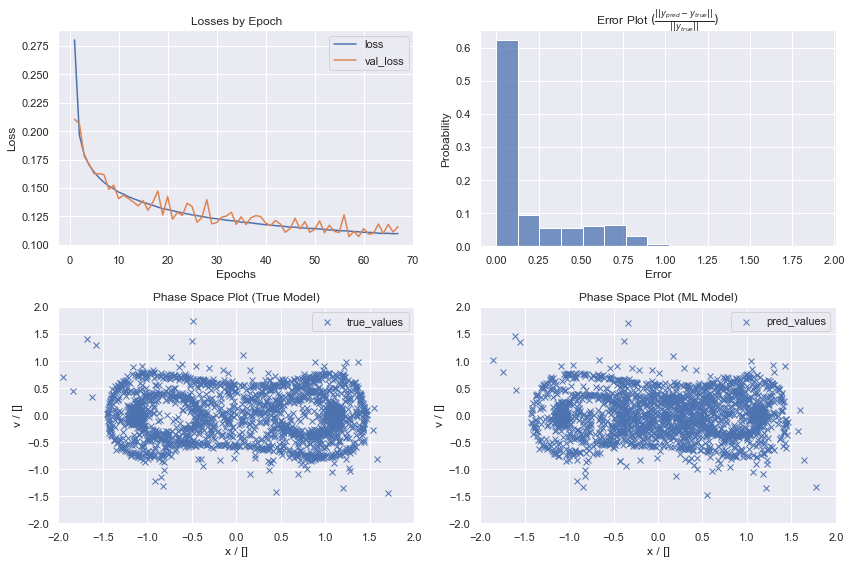

In [123]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.lineplot(data = history.history, x = epochs, y='loss',ax=axs[0,0], label='loss')
sns.lineplot(data = history.history, x = epochs, y='val_loss',ax=axs[0,0], label='val_loss')

axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("Losses by Epoch")
axs[0,0].legend()



sns.scatterplot(data = y_test.iloc[:2000,:], x = 'xt', y='vt',ax=axs[1,0],label='true_values', marker='x', linewidth = 1)

axs[1,0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,0].set_xlabel('x / []')
axs[1,0].set_ylabel('v / []')
axs[1,0].set_title("Phase Space Plot (True Model)")


sns.scatterplot(data = y_pred.iloc[:2000,:], x='xt', y='vt',ax=axs[1,1],label='pred_values',  marker='x', linewidth = 1)

axs[1,1].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,1].set_xlabel('x / []')
axs[1,1].set_ylabel('v / []')
axs[1,1].set_title("Phase Space Plot (ML Model)")


sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', bins=15, ax=axs[0,1])

axs[0,1].set_xlabel('Error')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")



f.tight_layout()

f.savefig("ml_model_1_delta03_no_val_cutoff.svg", dpi='figure')

In [60]:
class TrueModel():
    def __init__(self, scaler):
        self.alpha=-1
        self.beta=1
        self.delta=0.3
        self.gamma=0.37
        self.omega=1.2
        self.scaler = scaler
        
    def inv_transform(self, X):
        return pd.DataFrame(self.scaler.inverse_transform(X), columns=['x0','v0','t'])
       
    def eom(self, u, t):
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X):
        X = self.inv_transform(X)
        X_res = np.ones((np.shape(X)[0], 2))
        for i in range(0,np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i], 500, endpoint=False)
            X_res[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
            
        return X_res


In [61]:
true_model = TrueModel(scaler)


In [105]:
import shap

background = X_train_scale.iloc[np.random.choice(X_train_scale.shape[0], 1000, replace=False)]

true_explainer = shap.explainers.Permutation(true_model.predict, background)
explainer = shap.explainers.Permutation(model.predict, background)

In [106]:
true_values = true_explainer(X_test_scale.iloc[:1000,:])
model_values = explainer(X_test_scale.iloc[:1000,:])

Permutation explainer: 1001it [5:53:11, 21.19s/it]                           
Permutation explainer: 1001it [07:43,  2.12it/s]                          


In [107]:

print("shap_values =", true_values.values)




print("shap_values =", model_values.values)


shap_values = [[[-0.42271666 -0.03881337]
  [-0.17325787 -0.01632972]
  [-0.61039129 -0.14371742]]

 [[ 0.05014452  0.17767186]
  [ 0.34493438  0.27553886]
  [ 0.13806939 -0.06737018]]

 [[ 0.12730651  0.0486499 ]
  [ 0.06377249  0.17877169]
  [-0.01528181  0.36699122]]

 ...

 [[-0.20075828  0.02721283]
  [ 0.2850026   0.12214972]
  [ 0.5097294   0.08269883]]

 [[ 0.3764478  -0.14559685]
  [ 0.02418146 -0.04413771]
  [ 0.42695901 -0.15827753]]

 [[ 0.16708852  0.22575293]
  [-0.08276763 -0.02793275]
  [ 0.14405499  0.52376076]]]
shap_values = [[[-0.71710219 -0.05685811]
  [-0.29163973 -0.05616334]
  [-0.15085654 -0.0197503 ]]

 [[-0.00384269 -0.00550814]
  [ 0.49409538 -0.02569758]
  [ 0.1350261  -0.16041901]]

 [[ 0.13296677  0.23669695]
  [-0.02194898  0.08164654]
  [-0.00153828  0.24938185]]

 ...

 [[ 0.07926581  0.19840328]
  [ 0.3450263   0.13788353]
  [ 0.24278269 -0.06410108]]

 [[ 0.04241839 -0.06777869]
  [ 0.0392453  -0.03687901]
  [ 0.74135535 -0.22720936]]

 [[ 0.00224537

In [108]:
true_explainer_partition = shap.explainers.Partition(true_model.predict, background)
explainer_partition = shap.explainers.Partition(model.predict, background)

In [ ]:
true_values_partition = true_explainer_partition(X_test_scale.iloc[:1000,:])
model_values_partition = explainer_partition(X_test_scale.iloc[:1000,:])

Partition explainer:  90%|████████▉ | 898/1000 [41:48<04:37,  2.72s/it]

In [ ]:
true_plotting_data = np.empty((len(true_values.values),6))
plotting_data = np.empty((len(true_values.values),6))

for i in range(len(true_values.values)):
    true_plotting_data[i,:] = true_values_partition.values[i].flatten()
    plotting_data[i,:] = model_values_partition.values[i].flatten()
    
true_plot_data = pd.DataFrame(true_plotting_data, columns = ['x0_xt', 'v0_xt', 't_xt', 'x0_vt', 'v0_vt', 't_vt'])
plot_data = pd.DataFrame(plotting_data, columns = ['x0_xt', 'v0_xt', 't_xt', 'x0_vt', 'v0_vt', 't_vt'])

In [ ]:
plot_data.index

In [ ]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4, 4]))



sns.scatterplot(data = plot_data, x = plot_data.index,  y='x0_xt', label = 'model', ax=axs[0,0])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='x0_xt', label='true',ax=axs[0,0])
axs[0,0].set_title(r"Feature Contribution of $x_0$ to $x_t$")
axs[0,0].set_xlabel('Index / []')
axs[0,0].set_ylabel('Feature Contribution / []')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='v0_xt', label = 'model', ax=axs[0,1])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='v0_xt', label='true',ax=axs[0,1])
axs[0,1].set_title(r"Feature Contribution of $v_0$ to $x_t$")
axs[0,1].set_xlabel('Index / []')
axs[0,1].set_ylabel('Feature Contribution / []')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='t_xt', label = 'model', ax=axs[0,2])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='t_xt', label='true',ax=axs[0,2])
axs[0,2].set_title(r"Feature Contribution of $t$ to $x_t$")
axs[0,2].set_xlabel('Index / []')
axs[0,2].set_ylabel('Feature Contribution / []')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='x0_vt', label = 'model', ax=axs[1,0])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='x0_vt', label='true',ax=axs[1,0])
axs[1,0].set_title(r"Feature Contribution of $x_0$ to $v_t$")
axs[1,0].set_xlabel('Index / []')
axs[1,0].set_ylabel('Feature Contribution / []')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='v0_vt', label = 'model', ax=axs[1,1])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='v0_vt', label='true',ax=axs[1,1])
axs[1,1].set_title(r"Feature Contribution of $v_0$ to $v_t$")
axs[1,1].set_xlabel('Index / []')
axs[1,1].set_ylabel('Feature Contribution / []')

sns.scatterplot(data = plot_data, x = plot_data.index,  y='t_vt', label = 'model', ax=axs[1,2])
sns.scatterplot(data = true_plot_data, x = true_plot_data.index,  y='t_vt', label='true',ax=axs[1,2])
axs[1,2].set_title(r"Feature Contribution of $t$ to $v_t$")
axs[1,2].set_xlabel('Index / []')
axs[1,2].set_ylabel('Feature Contribution / []')


f.tight_layout()

f.savefig("1delta03shap1000.svg", dpi='figure')

In [104]:
true_model.predict(true_values_partition.data)

array([[-1.0856429 , -0.1424548 ],
       [ 0.65387121,  0.44224625],
       [ 0.29652012,  0.65081851],
       [ 0.98189356, -0.59313827],
       [ 0.25650031,  0.12651628],
       [-0.83689298, -0.46171038],
       [-1.06245511,  0.67979776],
       [-0.57302199, -0.43981688],
       [ 1.12904028, -0.75063611],
       [-0.03999175, -0.56510169],
       [ 1.39123203,  0.24694902],
       [-0.16235372,  0.8397654 ],
       [ 0.37937339,  0.09592802],
       [-0.64934156,  0.89666478],
       [-1.26004293, -0.64115538],
       [ 0.75535785, -0.47249657],
       [ 1.0564678 , -0.16833258],
       [-0.80802113, -1.00443004],
       [-0.60863797,  0.33385392],
       [-1.22049192, -0.01466773],
       [ 0.52472362, -0.16980474],
       [ 1.21923583, -0.23496767],
       [-0.61757236, -0.2484014 ],
       [-1.06685468, -0.1101226 ],
       [-0.83542821,  0.68894223],
       [ 0.86159308, -0.83487222],
       [ 0.59130908, -0.77492062],
       [ 0.91842086, -0.62877594],
       [-1.28095123,

In [77]:
X_test_scale

,x0,v0,t
0,-1.464767,-0.156468,-0.529506
1,-1.089621,0.546080,-0.127674
2,0.424450,0.307538,-0.183099
3,-1.698037,-0.680542,-0.522578
4,-1.313189,0.320245,-0.827417
...,...,...,...
99995,0.650856,-0.098344,-1.180752
99996,-1.493803,-0.959856,-1.347028
99997,-0.199808,-1.303464,0.371153
99998,1.559158,1.116949,1.569722


In [96]:
np.shape((true_values_partition.values[1][:,0]/true_model.predict(true_values_partition.data)[1,0]).T)

(3,)

In [102]:
def aggregator(X_explainer, model):
    """
    Data aggregator for SHAP values. Normalises each contribution: 
    (feature contribution/data point) and aggregates over the supplied examples
    Inputs
    --------
    shapley values: 
    data: 
    """
    aggregated_array = np.empty_like(X_explainer.values[0])
    preds = model.predict(X_explainer.data)
    
    for i in range(len(X_explainer.values)):
        aggregated_array = (aggregated_array + 
                            np.hstack((
                                (np.abs(X_explainer.values[i][:,0])/preds[i,0]).reshape((3,1)), 
                                (np.abs(X_explainer.values[i][:,1]/preds[i,1])).reshape((3,1)))))
        
    return aggregated_array/len(X_explainer.values)

In [103]:
aggregator(true_values_partition, true_model)

array([[0.04978515, 1.07869722],
       [0.09664907, 0.5848456 ],
       [0.02440785, 1.6339182 ]])

In [140]:
import lime
import lime.lime_tabular

In [144]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_scale), verbose=True, mode='regression')

In [226]:


i = 25
lime_exp_model = lime_explainer.explain_instance(X_test_scale.iloc[i], model.predict, num_features=3)
lime_exp_true = lime_explainer.explain_instance(X_test_scale.iloc[i], true_model.predict, num_features=3)


Intercept -0.008174646860849484
Prediction_local [-0.01416116]
Right: 0.4407811
Intercept -0.13453943131738033
Prediction_local [0.520284]
Right: 0.6907805384290252


Permutation explainer: 2it [00:20, 20.24s/it]               


.values =
array([[[ 0.13357576, -0.03780468],
        [-0.07799325, -0.01157501],
        [ 0.28196694, -0.22487967]]])

.base_values =
array([[ 0.10323171, -0.04488727]])

.data =
array([[ 0.55628377, -1.37531385,  0.25337406]])

In [229]:
true_explainer(X_test_scale.iloc[i:i+1,:]).values

Permutation explainer: 2it [00:20, 20.06s/it]               


array([[[ 0.91506568,  0.01874825],
        [-0.154836  , -0.00132026],
        [ 0.03901475, -0.32772624]]])

In [230]:
explainer(X_test_scale.iloc[i:i+1,:])

.values =
array([[[ 0.20146199, -0.05501359],
        [-0.0440292 , -0.01593001],
        [ 0.18011666, -0.20331575]]])

.base_values =
array([[ 0.10323171, -0.04488727]])

.data =
array([[ 0.55628377, -1.37531385,  0.25337406]])

In [221]:
lime_exp_model.show_in_notebook(show_table=True)

In [222]:
lime_exp_true.show_in_notebook(show_table=True)

In [154]:
X_test_scale.iloc[i]

x0    0.556284
v0   -1.375314
t     0.253374
Name: 25, dtype: float64

In [156]:
y_test.iloc[i]

xt    0.814063
vt   -0.826737
Name: 25, dtype: float64

In [205]:
model.predict(X_test_scale.iloc[i-1:i,:])

array([[-0.85049593,  0.64853054]], dtype=float32)

In [234]:
i =14
y_test.iloc[i-1:i,:]

print(model.predict(X_test_scale.iloc[i-1:i,:]))
print(true_model.predict(X_test_scale.iloc[i-1:i,:]))

[[-0.6504046   0.88857037]]
[[-0.7931893   0.58080985]]


In [232]:
y_test.iloc[i-1:i,:]

,xt,vt
13,-0.647907,0.895973


In [178]:
X_test[i-1:i,:]

array([[-0.11061691,  0.16235259, 24.4       ]])

In [191]:
scaler.inverse_transform(X_test_scale.iloc[i:i+1,:])

array([[-1.76025912, -0.68622392,  8.2       ]])

In [183]:
X_test[i-1]

array([-0.11061691,  0.16235259, 24.4       ])

In [190]:
X_test_scale.iloc[i-1:i,:]

,x0,v0,t
14,-0.096089,0.281499,-0.037608


In [189]:
[X_test_scale['x0'].iloc[i-1],X_test_scale['v0'].iloc[i-1]]

[-0.09608914894007081, 0.2814988633140982]

In [ ]:
def eom(self, u, t):
    x, dx = u[0], u[1]
    ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
    return [dx,ddx]
    
t_range = np.linspace(0, X['t'].iloc[i-1], 500, endpoint=False)   


In [ ]:
class TrueModel():
    def __init__(self, scaler):
        self.alpha=-1
        self.beta=1
        self.delta=1#0.3
        self.gamma=0.37
        self.omega=1.2
        self.scaler = scaler
        
    def inv_transform(self, X):
        return pd.DataFrame(self.scaler.inverse_transform(X), columns=['x0','v0','t'])
       
    def eom(self, u, t):
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X):
        X = self.inv_transform(X)
        X_res = np.ones((np.shape(X)[0], 2))
        for i in range(np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i-1], 500, endpoint=False)
            X_res[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
            
        return X_res